# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [80]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, softmax_with_cross_entropy, l2_regularization
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

import sys
sys.path.append('..')
from assignment1.linear_classifer import softmax

# Загружаем данные

И разделяем их на training и validation.

In [81]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../assignment1/data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [210]:
class ReLULayer:
    def __init__(self):
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        self.X = np.copy(X)
        output = self._reLU(self.X)
        
        return output
    
    def _reLU(self, x):
        x[x < 0] = 0
        return x
    
    def backward(self, d_out):
        """
        Backward pass

        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops

        d_result = d_out * self._grad_reLU(self.X)

        return d_result
    
    def _grad_reLU(self, x):
        x[x > 0] = 1
        x[x < 0] = 0
        return x

    def params(self):
        # ReLU Doesn't have any parameters
        return {}

In [211]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2, 3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [212]:
class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)
        

class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        self.X = X
        return self.X @ self.W.value + self.B.value

    def backward(self, d_out):
        """
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B

        Arguments:
        d_out, np array (batch_size, n_output) - gradient
           of loss function with respect to output

        Returns:
        d_result: np array (batch_size, n_input) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute

        # It should be pretty similar to linear classifier from
        # the previous assignment
        d_result = d_out @ self.W.value.T
        self.W.grad = self.X.T @ d_out
        self.B.grad = np.ones((self.B.value.shape[0], self.X.shape[0])) @ d_out
        
        return d_result

    def params(self):
        return {'W': self.W, 'B': self.B}

In [213]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [214]:
class TwoLayerNet:
    """ Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        """
        Initializes the neural network

        Arguments:
        n_input, int - dimension of the model input
        n_output, int - number of classes to predict
        hidden_layer_size, int - number of neurons in the hidden layer
        reg, float - L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        self.fc1 = FullyConnectedLayer(n_input, hidden_layer_size)
        self.relu1 = ReLULayer()
        self.fc2 = FullyConnectedLayer(hidden_layer_size, n_output)

    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples

        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!
        self._zero_grad()
        
        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model
        predictions = self._forward(X)
        loss, dprediction = softmax_with_cross_entropy(predictions, y)
        self._backward(dprediction)
        
        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        loss_l2 = self._backward_l2_regularization()
        loss += loss_l2
        
        return loss

    def _zero_grad(self):
        for param in self.params().values():
            param.grad = np.zeros_like(param.value)
                
    def _forward(self, X):
        output = self.fc1.forward(X)
        output = self.relu1.forward(output)
        output = self.fc2.forward(output)
        return output
    
    def _backward(self, dprediction):
        grad = self.fc2.backward(dprediction)
        grad = self.relu1.backward(grad)
        self.fc1.backward(grad)
        
    def _backward_l2_regularization(self):
        loss_l2 = 0.
        
        for param in self.params().values():
            param_loss_l2, param_grad_l2 = l2_regularization(param.value, self.reg)
            param.grad += param_grad_l2
            loss_l2 += param_loss_l2
                
        return loss_l2
    
    def predict(self, X):
        """
        Produces classifier predictions on the set

        Arguments:
          X, np array (test_samples, num_features)

        Returns:
          y_pred, np.array of int (test_samples)
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused
        pred = np.zeros(X.shape[0], np.int)

        predictions = self._forward(X)
        y_pred = np.argmax(softmax(predictions), axis=1)

        return y_pred

    def params(self):
        result = {}

        # TODO Implement aggregating all of the params
        for k, v in self.fc2.params().items():
            result["".join(["fc2_", k])] = v
        
        for k, v in self.fc1.params().items():
            result["".join(["fc1_", k])] = v
            

        
        return result

In [215]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for fc2_W
Gradient check passed!
Checking gradient for fc2_B
Gradient check passed!
Checking gradient for fc1_W
Gradient check passed!
Checking gradient for fc1_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [216]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for fc2_W
Gradient check passed!
Checking gradient for fc2_B
Gradient check passed!
Checking gradient for fc1_W
Gradient check passed!
Checking gradient for fc1_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [217]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [218]:
from copy import deepcopy

import numpy as np
from metrics import multiclass_accuracy


class Dataset:
    """
    Utility class to hold training and validation data
    """

    def __init__(self, train_X, train_y, val_X, val_y):
        self.train_X = train_X
        self.train_y = train_y
        self.val_X = val_X
        self.val_y = val_y


class Trainer:
    """
    Trainer of the neural network models
    Perform mini-batch SGD with the specified data, model,
    training parameters and optimization rule
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2,
                 learning_rate_decay=1.0):
        """
        Initializes the trainer

        Arguments:
        model - neural network model
        dataset, instance of Dataset class - data to train on
        optim - optimization method (see optim.py)
        num_epochs, int - number of epochs to train
        batch_size, int - batch size
        learning_rate, float - initial learning rate
        learning_rate_decal, float - ratio for decaying learning rate
           every epoch
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        """
        Computes accuracy on provided data using mini-batches
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        """
        Trains a model
        """
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                # TODO Generate batches based on batch_indices and
                # use model to generate loss and gradients for all
                # the params
                train_X_batch = self.dataset.train_X[batch_indices]
                train_y_batch = self.dataset.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(train_X_batch, train_y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

            if np.not_equal(self.learning_rate_decay, 1.0):
                # TODO: Implement learning rate decay
                self.learning_rate *= self.learning_rate_decay

            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)

            print("Loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history


In [235]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 38.788797, Train accuracy: 0.291222, val accuracy: 0.296000
Loss: 34.581970, Train accuracy: 0.509333, val accuracy: 0.521000
Loss: 38.183085, Train accuracy: 0.524556, val accuracy: 0.519000
Loss: 39.485359, Train accuracy: 0.483333, val accuracy: 0.490000
Loss: 40.103090, Train accuracy: 0.536889, val accuracy: 0.557000
Loss: 35.628242, Train accuracy: 0.569889, val accuracy: 0.569000
Loss: 36.098885, Train accuracy: 0.596333, val accuracy: 0.588000
Loss: 43.473027, Train accuracy: 0.512111, val accuracy: 0.505000
Loss: 37.037030, Train accuracy: 0.560556, val accuracy: 0.557000
Loss: 29.349726, Train accuracy: 0.594222, val accuracy: 0.589000
Loss: 28.589663, Train accuracy: 0.562000, val accuracy: 0.535000
Loss: 33.786232, Train accuracy: 0.567444, val accuracy: 0.561000
Loss: 44.761444, Train accuracy: 0.572667, val accuracy: 0.548000
Loss: 30.653142, Train accuracy: 0.602444, val accuracy: 0.602000
Loss: 29.251393, Train accuracy: 0.573556, val accuracy: 0.556000
Loss: 34.1

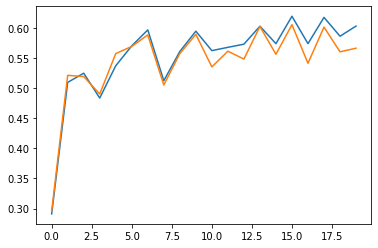

In [236]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

In [239]:
class SGD:
    """
    Implements vanilla SGD update
    """
    def update(self, w, d_w, learning_rate):
        """
        Performs SGD update

        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate

        Returns:
        updated_weights, np array same shape as w
        """
        return w - d_w * learning_rate


class MomentumSGD:
    """
    Implements Momentum SGD update
    """
    def __init__(self, momentum=0.9):
        self.momentum = 0.9
        self.velocity = 0.
    
    def update(self, w, d_w, learning_rate):
        """
        Performs Momentum SGD update

        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate

        Returns:
        updated_weights, np array same shape as w
        """
        # TODO Implement momentum update
        # Hint: you'll need to introduce some variables to remember
        # velocity from the previous updates
        self.velocity = self.momentum * self.velocity - learning_rate * d_w
        return w + self.velocity

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [238]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 43.857483, Train accuracy: 0.342111, val accuracy: 0.359000
Loss: 34.687301, Train accuracy: 0.501556, val accuracy: 0.508000
Loss: 38.078841, Train accuracy: 0.566667, val accuracy: 0.551000
Loss: 33.205475, Train accuracy: 0.610889, val accuracy: 0.578000
Loss: 32.146802, Train accuracy: 0.569000, val accuracy: 0.560000
Loss: 35.615097, Train accuracy: 0.591778, val accuracy: 0.586000
Loss: 32.021189, Train accuracy: 0.621556, val accuracy: 0.614000
Loss: 36.386294, Train accuracy: 0.594111, val accuracy: 0.582000
Loss: 29.512769, Train accuracy: 0.590667, val accuracy: 0.581000
Loss: 33.818260, Train accuracy: 0.525889, val accuracy: 0.545000
Loss: 29.252114, Train accuracy: 0.608667, val accuracy: 0.599000
Loss: 26.938574, Train accuracy: 0.627778, val accuracy: 0.611000
Loss: 40.321376, Train accuracy: 0.498778, val accuracy: 0.494000
Loss: 31.402516, Train accuracy: 0.639444, val accuracy: 0.622000
Loss: 41.973961, Train accuracy: 0.563667, val accuracy: 0.567000
Loss: 39.1

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [240]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 46.923704, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.937362, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.467947, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.817642, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.703310, Train accuracy: 0.210889, val accuracy: 0.215000
Loss: 44.685016, Train accuracy: 0.250778, val accuracy: 0.253000
Loss: 43.820789, Train accuracy: 0.266667, val accuracy: 0.266000
Loss: 44.991675, Train accuracy: 0.281444, val accuracy: 0.282000
Loss: 42.414458, Train accuracy: 0.318556, val accuracy: 0.315000
Loss: 34.576347, Train accuracy: 0.373556, val accuracy: 0.366000
Loss: 39.035691, Train accuracy: 0.406444, val accuracy: 0.389000
Loss: 40.551145, Train accuracy: 0.442667, val accuracy: 0.431000
Loss: 34.782584, Train accuracy: 0.453444, val accuracy: 0.445000
Loss: 31.898344, Train accuracy: 0.501222, val accuracy: 0.494000
Loss: 36.331255, Train accuracy: 0.524222, val accuracy: 0.517000
Loss: 35.3

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [247]:
data_size = 15
num_epochs = 150
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=num_epochs, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 11.546386, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.581033, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.429926, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 11.511984, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 11.415357, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.446580, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 11.474375, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.404837, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.275919, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.413152, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.289136, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.163226, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.059848, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 10.919125, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 11.488796, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 11.1

Loss: 2.015812, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.129875, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.991063, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.821753, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.829974, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.534522, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.833015, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.211252, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.946496, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.873620, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.147194, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.874260, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.184137, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.861341, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 2.086669, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.967441, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [364]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less
num_epochs = 20

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 300, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.1, num_epochs=num_epochs, batch_size=15,
                 learning_rate_decay=0.92)

loss_history, train_history, val_history = trainer.fit()

Loss: 34.536834, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 33.700228, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 32.619223, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 28.333945, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 23.539553, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 24.309329, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 30.342126, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 34.640622, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 74.867586, Train accuracy: 0.266667, val accuracy: 0.200000
Loss: 223.574746, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 216.439947, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 111.986009, Train accuracy: 0.466667, val accuracy: 0.333333
Loss: 190.227188, Train accuracy: 0.733333, val accuracy: 0.133333
Loss: 43.060457, Train accuracy: 0.666667, val accuracy: 0.200000
Loss: 17.460487, Train accuracy: 0.800000, val accuracy: 0.133333
Loss: 

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [372]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-2
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 50
batch_size = 64
momentum = 0.9

best_classifier = None
best_val_accuracy = None

best_loss_history = []
best_train_history = []
best_val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, 
                    hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(momentum), learning_rate=learning_rates, 
                  learning_rate_decay=learning_rate_decay, num_epochs=num_epochs, batch_size=batch_size)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()
val_multiclass_accuracy = multiclass_accuracy(model.predict(val_X), val_y)

if val_multiclass_accuracy > 0.6:
    best_val_accuracy = val_multiclass_accuracy
    best_classifier = model
    best_loss_history = loss_history
    best_train_history = train_history
    best_val_history = val_history
    
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 88.687688, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 88.061177, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 89.472635, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 91.814047, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 82.001368, Train accuracy: 0.212778, val accuracy: 0.221000
Loss: 81.864798, Train accuracy: 0.264667, val accuracy: 0.265000
Loss: 77.033199, Train accuracy: 0.296000, val accuracy: 0.298000
Loss: 77.601747, Train accuracy: 0.357778, val accuracy: 0.361000
Loss: 52.032447, Train accuracy: 0.418444, val accuracy: 0.413000
Loss: 61.035997, Train accuracy: 0.470000, val accuracy: 0.445000
Loss: 68.823540, Train accuracy: 0.513111, val accuracy: 0.504000
Loss: 58.323819, Train accuracy: 0.534444, val accuracy: 0.531000
Loss: 50.007609, Train accuracy: 0.582111, val accuracy: 0.569000
Loss: 52.249678, Train accuracy: 0.616222, val accuracy: 0.594000
Loss: 43.325887, Train accuracy: 0.630444, val accuracy: 0.620000
Loss: 54.5

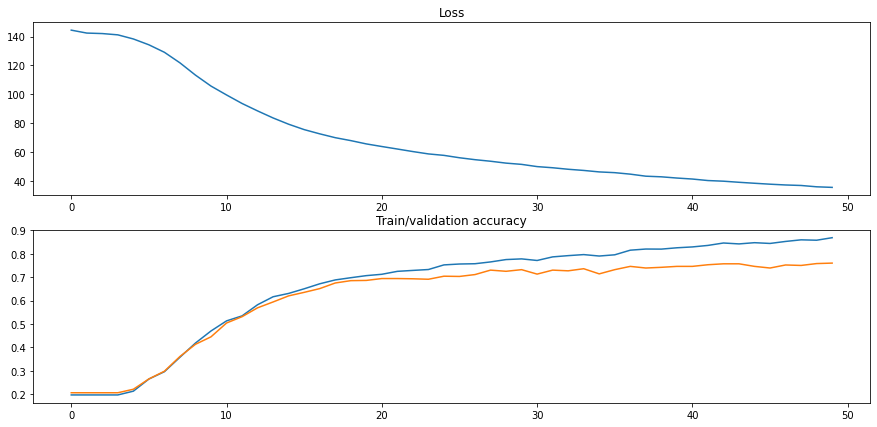

In [373]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(best_loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(best_train_history)
plt.plot(best_val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [374]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.729000
